# Coursework 

**Initialize packages**

In [24]:
using JuMP, HiGHS, Plots, DataFrames, CSV, Statistics;

**Reading Data**

In [25]:
flex_avail = DataFrame(CSV.File("input_files/Flexible_load_availability.csv"));

In [26]:
generators = DataFrame(CSV.File("input_files/Generators_data.csv"));


In [27]:
new_col_names = string.(generators.R_ID);  # Convert to String

In [28]:
gen_var = DataFrame(CSV.File("input_files/Generators_variability.csv"))
gen_var=gen_var[:,2:39];
rename!(gen_var, new_col_names);

In [29]:
load = DataFrame(CSV.File("input_files/Load_data.csv"));
load=load[:,9:15];

In [30]:
network = DataFrame(CSV.File("input_files/Network.csv"));

### Problem formulation


**SETS**

$\begin{align}
& N & \text{Set for zones [1:6]}\\[6pt]
& L & \text{Set for Transmission Lines [1:10]}\\[6pt]
& H  &  \text{Set of hours in the year [1:8736]}\\[6pt]
& H_2 & \text{Set of hours for Storage Operation [2:8736]}\\[6pt]
& Storage & \text{Set for storage[6 batteries, one per zone]}\\[6pt]
& Gen & \text{Set for generators }\\[6pt]
& Id_{STORAGE} & \text{Set for storage Id}\\[6pt]
& Id_{Gen} & \text{Set for Gen Id }\\[6pt]
& Zone & \text{Set for zones [1:6]}\\[6pt]
\end{align}$

**Parameters**
- $Investment_g$ annuitized capacity of Generator $g$ investment cost (annual cost, $/MW-year)
- $Investment_s$ annuitized capacity of Storage $s$ investment cost (annual cost, $/MW-year)
- $FixedOM_g$, the fixed operations and maintenance cost of Generator $g$(\$/MW-year)
- $FixedOM_s$, the fixed operations and maintenance cost of Storage $s$(\$/MW-year)
- $VarOM_g$, the variable operations and maintenance cost (\$/MWh);
- $HeatRate_g$, the rate of fuel consumed per unit of electricity produced (MMBtu/MWh);
- $FuelCost_g$, the cost of fuel (\$/MMBtu)
- $NSECost$, the opportunity cost or penalty incurred for involuntary non-served energy (\$/MWh); and
- $Demand_h$, is the demand in each hour (MW).
- $MaxFlow_{ij}$, the maximum allowable flow along the line from $i$ to $j$ (MW)
- $CF_{g,h}$, hourly profile of Generator $g$ (per unit).
- $Eff_s$, efficiency of the charge/discharge cycle.
- $SOC^{max}$, maximum state of char capacity (MWh).

**Variables**
$\begin{align}
&\text{Capacity variable only for new build:}&\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in Generators\\[6pt]
&\text{Capacity variable for Storage:}&\\[6pt]
& 0 \leq CAP_s \leq 100 MW & \forall \quad s \in Storage\\[6pt]
&\text{Generation variable:}&\\[6pt]
& GEN_{g,h} \geq 0 & \forall \quad g \in NEW_{GEN}  ,  & \forall \quad h \in Hours \\[6pt]
&\text{Not Served Energy:}&\\[6pt]
& NSE_{h} \geq 0 & \forall \quad h \in H \\[6pt]
&\text{Flow variable:}&\\[6pt]
& FLOW_{l,h} & \forall \quad l \in Transmission_{Lines}  ,  & \forall \quad h \in Hours\\[6pt]
&\text{Discharge variable:}&\\[6pt]
& DISCHARGE_{s,h} \geq 0 & \forall \quad s \in Storage  ,  & \forall \quad h \in Hours\\[6pt]
&\text{Charge variable:}&\\[6pt]
& CHARGE_{s,h} \geq 0 & \forall \quad s \in Storage  ,  & \forall \quad h \in Hours\\[6pt]
&\text{State of Charge variable:}&\\[6pt]
& 0\% \leq SOC_{s,h} \leq 100\%  & \forall \quad s \in Storage  ,  & \forall \quad h \in Hours\\[6pt]
\end{align}$

**Objective Function**
$\begin{align}
\min &\sum_{g \in Gen} FixedCost_g \times CAP_g + \sum_{g\in Gen}\sum_{h \in H} VarCost_g \times GEN_{g,h} +\\[6pt]
&\quad\quad \sum_{h \in H} NSECost \times NSE_h  + \sum_{s \in Storage} FixedCost_s \times CAP_s \\[6pt]
\end{align}$

$\begin{align}
\ FixedCost_g = Investment_g + FixedOM_g\\[6pt]
\ VarCost_g = VarOM_g + FuelCost_g \times HeatRate_g \\[6pt]
\ FixedCost_s = Investment_s + FixedOM_s\\[6pt]
\end{align}$

**Constraints**
$\begin{align}
&\text{Capacity constraint for nuclear:}&\\[6pt]
& GEN_{Nuclear,h} = CAP_{Nuclear} & \forall h \in H\\[6pt]
&\text{Capacity constraint for new generators:}&\\[6pt]
& 0 \leq  GEN_{g,h} \leq CAP_g \times CF_{g,h} & \forall \quad g \in GEN, h \in H\\[6pt]
&\text{Supply demand balance constraint:}&\\[6pt]
&\sum_{g \in Gen} GEN_{g,h,i} - Demand_{h,i} + \sum_{s \in Storage} (DISCHARGE_{s,h,i} -CHARGE_{s,h,i} ) + NSE_{h,i}  = \sum_{j \in J_i} FLOW_{ij} & \forall \quad i \in \text{N} &, & \forall \quad h \in \text{H}\\
&\text{Thermal limit constraint:}&\\[6pt]
& |FLOW_{ij}| \leq MaxFlow_{ij} & \forall \quad i \in \text{N} &, & \forall j \in J_i \\
&\text{Flow direction constraint:}&\\[6pt]
& FLOW_{ij} = - FLOW_{ji} & \forall \quad i, j \in \text{N} \\
&\text{State of Charge constraint:}&\\[6pt]
& SOC_{s,h}=SOC_{s,h-1} + \big(CHARGE_{s,h} * Eff_s - \frac{DISCHARGE_{s,h}}{Eff_s}\big)  & \forall \quad s \in Storage, h \in H_2 \\[6pt]
&\text{Initial and Final State of Charge constraint:}&\\[6pt]
& SOC_{s,1} = SOC_{s,t_{end}} = 50\% *SOC_{s}^{max}& \forall \quad s \in Storage\\[6pt]
&\text{Disharge Rate constraint:}&\\[6pt]
& 0 \leq DISCHARGE_{s,h} \leq CAP_s  & \forall \quad s \in Storage,  h \in H\\[6pt]
&\text{Charge Rate constraint:}&\\[6pt]
& 0 \leq CHARGE_{s,h} \leq  CAP_s  & \forall \quad s \in Storage,  h \in H\\[6pt]
&\text{State of Charge constraint:}&\\[6pt]
& 0 \leq SOC_{s,h} \leq SOC_{s}^{max}& \forall \quad s \in Storage, h \in H\\[6pt]
\end{align}$


**CASE 1: NO FLEXIBILITY**

**Sets**

In [31]:
N=[1,2,3,4,5,6]; #zones
L=[1,2,3,4,5,6,7,8,9,10]; # transmission lines

In [32]:
# The set of hours in the demand DataFrame
H = load.Time_index; # same for every zone

In [33]:
H_2 = H[2:end]; # to avoid the first hour 

In [34]:
# Storage
storage = generators[generators.Resource .== "battery", :];

In [35]:
# Generators
gen = generators[generators.Resource .!= "battery", :];

In [36]:
# Storage id
Id_storage=storage.R_ID;
# Generators id
Id_gen=gen.R_ID;
#Zones
Zone_gen=gen.Zone;

**Define the Incident Matrix**

In [37]:
# Define the Incident Matrix
A = [
    1   -1   0    0    0    0;
    1    0  -1    0    0    0;
    0    1  -1    0    0    0;
    0    1   0   -1    0    0;
    0    0   1   -1    0    0;
    0    0   0    1   -1    0;
    0    0   0    1    0   -1;
    1    0   0    0   -1    0;
    0    1   0    0   -1    0;
    0    0   1    0   -1    0
];

**Model**

In [38]:
NoFlex_Model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

**Variables**

In [39]:
@variables(NoFlex_Model, begin
    # Generating capacity (MW)
    CAP[g in Id_gen] >= 0
    # Storage capacity (MW)
    100 >= CAP_stor[s in Id_storage] >= 0
    
    # Generation in each hour (MWh)
    GEN[g in Id_gen, h in H] >= 0
    
    # Non-served energy in each hour (MWh) – currently uses zones 1:6
    NSE[h in H, z in N] >= 0
    
    # Flow
    FLOW[l in L, h in H]
    
    # Storage operations (charge/discharge in MW, SOC in MWh)
    
    0 <= DISCHARGE[s in Id_storage, h in H]
    0 <= CHARGE[s in Id_storage, h in H]    
    0 <= SOC[s in Id_storage, h in H]       
    
end);





**Constraints**

In [40]:
@constraints(NoFlex_Model, begin

#Inflexibility of Nuclear Plants
NuclearInflexibility[id in Id_gen ∩ gen[gen.Resource .== "nuclear", :R_ID], h in H], GEN[id, h] == CAP[id]

#Generation Capacity
Generation[id in Id_gen,h in H], GEN[id,h]<=CAP[id] * gen_var[h,string(id)]   

#Supply Demand Balance
cBalance1[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 1,:R_ID]) - load.Load_MW_z1[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID]) + NSE[h,1]== sum(A[l,1]*FLOW[l,h] for l in L) ;  
cBalance2[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 2,:R_ID]) - load.Load_MW_z2[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID]) + NSE[h,2]== sum(A[l,2]*FLOW[l,h] for l in L) ;   
cBalance3[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 3,:R_ID]) - load.Load_MW_z3[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID]) + NSE[h,3]== sum(A[l,3]*FLOW[l,h] for l in L) ;
cBalance4[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 4,:R_ID]) - load.Load_MW_z4[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID]) + NSE[h,4]== sum(A[l,4]*FLOW[l,h] for l in L) ;  
cBalance5[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 5,:R_ID]) - load.Load_MW_z5[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID]) + NSE[h,5]== sum(A[l,5]*FLOW[l,h] for l in L) ;  
cBalance6[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 6,:R_ID]) - load.Load_MW_z6[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID]) + NSE[h,6]== sum(A[l,6]*FLOW[l,h] for l in L) ;

#Thermal constraint
Positive_max_flow[l in L, h in H], FLOW[l,h] <= network[l,:Line_Max_Flow_MW]
Negative_max_flow[l in L, h in H], FLOW[l,h] >= -network[l,:Line_Max_Flow_MW]

#State of charge
StateOfCharge[s in Id_storage, h in H_2], SOC[s,h] == SOC[s,h-1] + storage[storage.R_ID.==s,:Charge_efficiency][1]*CHARGE[s,h] - DISCHARGE[s,h]/storage[storage.R_ID.==s,:Discharge_efficiency][1] # State of charge of storage units

#States initial condition for SOC level (assumes half SOC)
StateOfcharge_ini[s in Id_storage], SOC[s,1].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] 

#States final condition for SOC level (assumes half SOC)
StateOfcharge_end[s in Id_storage], SOC[s,8736].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] 

# Storage operations (charge/discharge in MW, SOC in MWh)
limitdis[s in Id_storage, h in H], DISCHARGE[s,h] <= CAP_stor[s]
limitcha[s in Id_storage, h in H], CHARGE[s,h]<= CAP_stor[s]
limitSOC[s in Id_storage, h in H], SOC[s,h] .<= CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s]

end);

**Objective function**

In [41]:
@objective(NoFlex_Model,Min,
sum(
(sum(gen[gen.R_ID.==id, :Inv_cost_per_MWyr])+sum(gen[gen.R_ID.==id, :Fixed_OM_cost_per_MWyr]))*CAP[id]+
sum(sum(gen[gen.R_ID.==id,:Var_OM_cost_per_MWh] .+ sum(gen[gen.R_ID.==id,:Heat_rate_MMBTU_per_MWh].*gen[gen.R_ID.==id,:Cost_per_MMBtu]))
*GEN[id,h] for h in H) for id in Id_gen)+
sum(NSE[h, z] for h in H, z in N)*9000+
sum((sum(storage[storage.R_ID.==id_s,:Inv_cost_per_MWyr]).+sum(storage[storage.R_ID.==id_s,:Fixed_OM_cost_per_MWyr]))*CAP_stor[id_s] for id_s in Id_storage)
)


245527.198 CAP[47] + 40.75520000000001 GEN[47,1] + 40.75520000000001 GEN[47,2] + 40.75520000000001 GEN[47,3] + 40.75520000000001 GEN[47,4] + 40.75520000000001 GEN[47,5] + 40.75520000000001 GEN[47,6] + 40.75520000000001 GEN[47,7] + 40.75520000000001 GEN[47,8] + 40.75520000000001 GEN[47,9] + 40.75520000000001 GEN[47,10] + 40.75520000000001 GEN[47,11] + 40.75520000000001 GEN[47,12] + 40.75520000000001 GEN[47,13] + 40.75520000000001 GEN[47,14] + 40.75520000000001 GEN[47,15] + 40.75520000000001 GEN[47,16] + 40.75520000000001 GEN[47,17] + 40.75520000000001 GEN[47,18] + 40.75520000000001 GEN[47,19] + 40.75520000000001 GEN[47,20] + 40.75520000000001 GEN[47,21] + 40.75520000000001 GEN[47,22] + 40.75520000000001 GEN[47,23] + 40.75520000000001 GEN[47,24] + 40.75520000000001 GEN[47,25] + 40.75520000000001 GEN[47,26] + 40.75520000000001 GEN[47,27] + 40.75520000000001 GEN[47,28] + 40.75520000000001 GEN[47,29] + [[...209642 terms omitted...]] + 9000 NSE[8733,1] + 9000 NSE[8733,2] + 9000 NSE[8733,3] +

In [42]:
optimize!(NoFlex_Model)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-04, 1e+01]
  Cost   [1e+01, 7e+05]
  Bound  [1e+02, 1e+02]
  RHS    [1e+02, 6e+04]
Presolving model
478500 rows, 513488 cols, 1540338 nonzeros  0s
478500 rows, 513488 cols, 1540338 nonzeros  1s
Presolve : Reductions: rows 478500(-272802); columns 513488(-63126); elements 1540338(-370884)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.2856708564e+01 Pr: 52416(4.86192e+08) 2s
      69904     3.1224169668e+10 Pr: 71347(2.36407e+08); Du: 0(1.9418e-05) 8s
     100536     5.1285096020e+10 Pr: 63999(2.55265e+08); Du: 0(1.66005e-05) 13s
     120454     5.7777738495e+10 Pr: 56963(2.05212e+08); Du: 0(1.35046e-05) 18s
     136108     6.1485133433e+10 Pr: 73899(8.10228e+08); Du: 0(1.22589e-05) 24s
     155670     6.5090225090e+10 Pr: 57121(2.26113e+08); Du: 0(1.08317e-05) 29s
     16

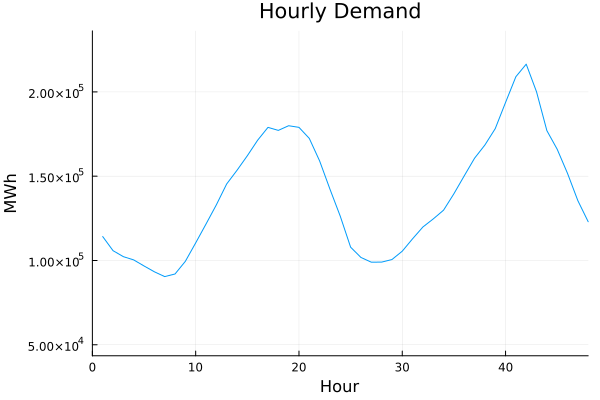

In [43]:
plot(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6, xlims=(0,48) ,label="")
title!("Hourly Demand")
xaxis!("Hour")
yaxis!("MWh")

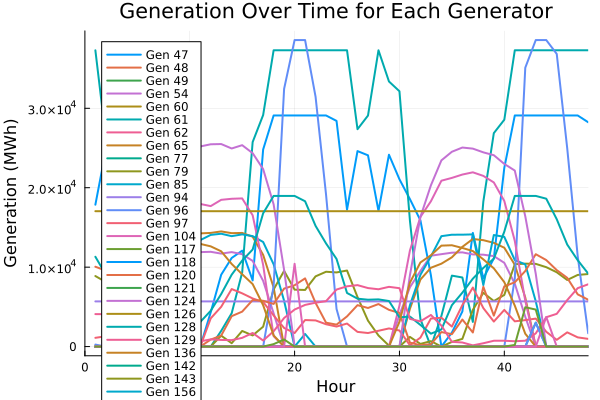

In [44]:
# Extract generation values for each generator and hour
########################################################

# Create empty arrays to store generator, hour, and generation values
generators = Int[]
hours = Int[]
generation_values = Float64[]

# Loop through each generator and hour, and store values
for g in Id_gen
    for h in H
        push!(generators, g)
        push!(hours, h)
        push!(generation_values, value(GEN[g, h]))
    end
end

# Create DataFrame from the collected values
df_gen_values = DataFrame(generator=generators, hour=hours, generation=generation_values)

#######################################################

#PLOT OF GENERATION
using Plots
# Create a plot
plot(xlims=(0,48))

# Loop through each generator and plot its generation over time
for g in unique(df_gen_values.generator)
    gen_data = df_gen_values[df_gen_values.generator .== g, :]
    plot!(gen_data.hour, gen_data.generation, label="Gen $g", linewidth=2)
end

# Labels and title
xlabel!("Hour")
ylabel!("Generation (MWh)")
title!("Generation Over Time for Each Generator")


In [45]:
# Extract storage capacities
stor_capacities = [(s, value(CAP_stor[s])) for s in Id_storage]

# Convert to a DataFrame
df_stor_capacities = DataFrame(storage_unit=first.(stor_capacities), 
                               capacity=last.(stor_capacities))

# Print the storage capacities
println(df_stor_capacities)

6×2 DataFrame
 Row │ storage_unit  capacity 
     │ Int64         Float64  
─────┼────────────────────────
   1 │           58     100.0
   2 │           75     100.0
   3 │           93     100.0
   4 │          116     100.0
   5 │          125     100.0
   6 │          141     100.0


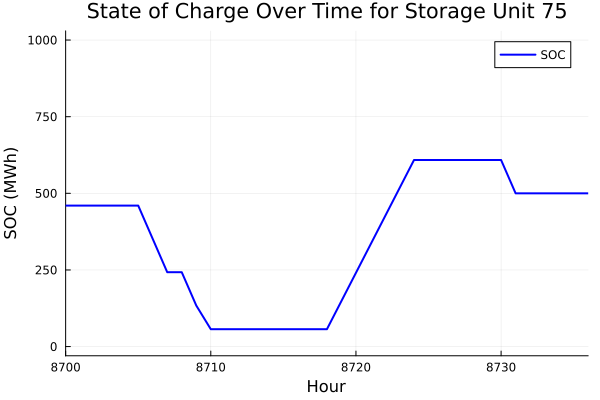

In [46]:
# Storage unit ID (Change as needed)
s_id = 75;  

# Create empty vectors for SOC and hours
soc_values = Float64[]
hours = Int[]

# Loop through each hour to extract SOC values for storage unit 's_id'
for h in H
    push!(soc_values, value(SOC[s_id, h]))  # Store SOC values
    push!(hours, h)  # Store the corresponding hour
end

# Create a plot
plot(hours, soc_values, label="SOC", linewidth=2, linestyle=:solid, color=:blue, xlims=(8700, maximum(H)))

# Add labels and title
xlabel!("Hour")
ylabel!("SOC (MWh)")
title!("State of Charge Over Time for Storage Unit $s_id")
